In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import torchsummary

In [2]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [3]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)  #+++++++++++++++
        self.linear = nn.Linear(512, num_classes) #++++++++

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1) #str + str
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        print(layers)
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out




In [4]:
def project1_model():
    return ResNet(BasicBlock, [1, 1, 1, 1]) #+++++++++++++



In [5]:
# Data Pretreatment
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # fill the margin as 0，then cut the image in 32*32 randomly
    transforms.RandomHorizontalFlip(),  # rotate with 50% probability
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # randomly normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # same as training set
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)   

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=8)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [6]:
#load the model
model = project1_model()

#select gpu 0, if available
# otherwise fallback to cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#transfer the model to the GPU
model = model.to(device)

#loss function
loss_function = nn.CrossEntropyLoss()

#optimizer all parameters
optimizer = optim.Adam(model.parameters())

[BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
)]
[BasicBlock(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)]
[BasicBlock(
  (conv1): Conv2d(1

In [7]:
torchsummary.summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]           8,192
      BatchNorm2d-13          [-1, 128, 16, 16]             256
       BasicBlock-14          [-1, 128,

In [8]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()



        sum_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

        train_loss=sum_loss / (batch_idx + 1)
        # train_acc=100. * correct / total
        train_acc=100. * correct / len(train_loader.dataset)

        
        if batch_idx % 100 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), 
                loss.item()))
    return train_loss, train_acc

In [9]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction = "sum").item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [10]:
train_loss_history = []##+++++
train_accuracy_history = []##++++
test_loss_history = []
test_accuracy_history = []

EPOCHS = 50
for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, trainloader, optimizer, epoch)#+++
    test_loss, test_accuracy = evaluate(model, testloader)
    train_loss_history.append(train_loss)#++
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)#++
    test_accuracy_history.append(test_accuracy)
    print("[{}] Train Loss: {:.4f}, accuracy: {:.2f}%\n".format(epoch, train_loss, train_accuracy))#++
    print("[{}] Test Loss: {:.4f}, accuracy: {:.2f}%\n".format(epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.407163
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.615555
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.307109
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.973773
[1] Train Loss: 1.3653, accuracy: 50.26%

[1] Test Loss: 1.2436, accuracy: 56.43%

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.855405
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.004900
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.905656
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.783766
[2] Train Loss: 0.9328, accuracy: 66.64%

[2] Test Loss: 0.8917, accuracy: 68.86%

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.728716
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.708446
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.663607
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.846213
[3] Train Loss: 0.7597, accuracy: 73.24%

[3] Test Loss: 0.7106, accuracy: 75.45%

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.559225
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.528940
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.717170
Train Epoch: 4 [38400

In [11]:
print(train_loss,train_accuracy)

0.044199471078489136 tensor(98.3760)


In [12]:
print(test_loss,test_accuracy)

0.4456373604774475 90.84


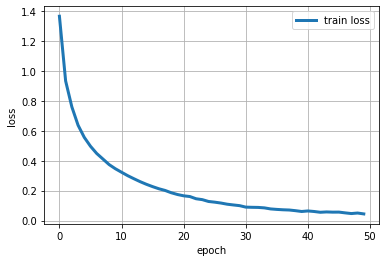

In [13]:
plt.plot(range(50),train_loss_history,'-',linewidth=3,label='train loss')
# plt.plot(range(2),test_accuracy_history,'-',linewidth=3,label='Test acc')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

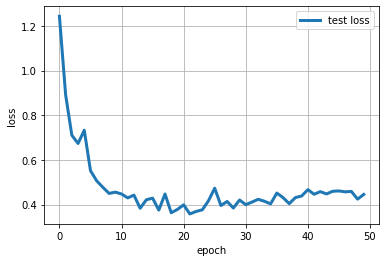

In [14]:
plt.plot(range(50),test_loss_history,'-',linewidth=3,label='test loss')
# plt.plot(range(2),test_accuracy_history,'-',linewidth=3,label='Test acc')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

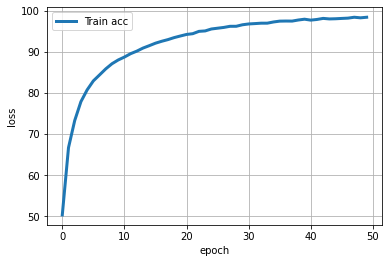

In [15]:
plt.plot(range(50),train_accuracy_history,'-',linewidth=3,label='Train acc')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

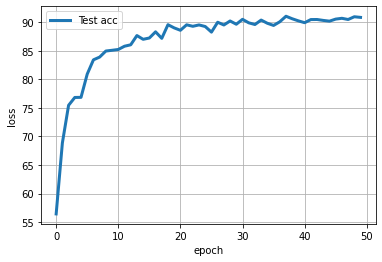

In [16]:
# plt.plot(range(2),test_loss_history,'-',linewidth=3,label='test loss')
plt.plot(range(50),test_accuracy_history,'-',linewidth=3,label='Test acc')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model))

4903242


In [18]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128,

In [19]:
model_path = './project1_model.pt'
torch.save(model.state_dict(), model_path)